# M4 Project: Enron Dataset Network Analysis
# COSC 545 - Digital Archeology
### Hayley Carney
### Alina Harrison-Trent
### George Vallejo
### Hugo Sandoval

#

In [1]:
# Cell 1: Imports and Configuration
import os
import re
from pathlib import Path
from email import policy
from email.parser import BytesParser
from email.utils import getaddresses, parsedate_to_datetime

import pandas as pd
import networkx as nx
from tqdm import tqdm

# ----- CONFIG -----
INPUT_MODE = 'dir'  # 'dir' for raw maildir structure, 'csv' for pre-flattened table
INPUT_PATH = '/path/to/your/enron/maildir'  # UPDATE THIS PATH!
CSV_FROM_COL = 'From'
CSV_TO_COLS = ['To', 'Cc', 'Bcc']
CSV_DATE_COL = 'Date'

# Pruning thresholds
MIN_EDGE_WEIGHT = 2  # drop edges with weight < this
KEEP_GIANT_COMPONENT = True
TOP_N_NODES = None

# Degree-driven pruning
AUTO_PRUNE_BY_DEGREE = True
PRUNE_DEGREE_MIN = None
PRUNE_DEGREE_QUANTILE = 0.9
PRUNE_DEGREE_TOP_N = None

# Optional time slicing
TIME_SLICE_FREQ = None
DATE_MIN = None
DATE_MAX = None

OUTPUT_DIR = './gephi_exports'
BASE_GEXF_NAME = 'enron_network_enhanced.gexf'
os.makedirs(OUTPUT_DIR, exist_ok=True)
EMAIL_RE = re.compile(r'<?([^<>@,\s]+@[^<>,\s]+)>?')

In [2]:
# Cell 2: Court Case Individuals Database
COURT_CASE_INDIVIDUALS = {
    # Executives convicted/pleaded guilty
    'kenneth.lay@enron.com': {'role': 'CEO', 'outcome': 'convicted'},
    'ken.lay@enron.com': {'role': 'CEO', 'outcome': 'convicted'},
    'jeff.skilling@enron.com': {'role': 'CEO', 'outcome': 'convicted'},
    'jeffrey.skilling@enron.com': {'role': 'CEO', 'outcome': 'convicted'},
    'andrew.fastow@enron.com': {'role': 'CFO', 'outcome': 'pleaded guilty'},
    'andy.fastow@enron.com': {'role': 'CFO', 'outcome': 'pleaded guilty'},
    'lea.fastow@enron.com': {'role': 'Treasury', 'outcome': 'pleaded guilty'},
    'michael.kopper@enron.com': {'role': 'Finance Executive', 'outcome': 'pleaded guilty'},
    'ben.glisan@enron.com': {'role': 'Treasurer', 'outcome': 'pleaded guilty'},
    'richard.causey@enron.com': {'role': 'CAO', 'outcome': 'pleaded guilty'},
    'rick.causey@enron.com': {'role': 'CAO', 'outcome': 'pleaded guilty'},
    'david.delainey@enron.com': {'role': 'CEO ENA/EES', 'outcome': 'pleaded guilty'},
    'dave.delainey@enron.com': {'role': 'CEO ENA/EES', 'outcome': 'pleaded guilty'},
    'mark.koenig@enron.com': {'role': 'Investor Relations', 'outcome': 'pleaded guilty'},
    'kenneth.rice@enron.com': {'role': 'CEO EBS', 'outcome': 'pleaded guilty'},
    'ken.rice@enron.com': {'role': 'CEO EBS', 'outcome': 'pleaded guilty'},
    'kevin.hannon@enron.com': {'role': 'COO EBS', 'outcome': 'pleaded guilty'},
    'michael.krautz@enron.com': {'role': 'Accounting', 'outcome': 'pleaded guilty'},
    'scott.yeager@enron.com': {'role': 'EBS Executive', 'outcome': 'acquitted'},
    'rex.shelby@enron.com': {'role': 'EBS Executive', 'outcome': 'acquitted'},
    'greg.whalley@enron.com': {'role': 'President', 'outcome': 'not charged'},
    'mark.frevert@enron.com': {'role': 'Vice Chairman', 'outcome': 'not charged'},
    'louise.kitchen@enron.com': {'role': 'COO EnronOnline', 'outcome': 'not charged'},
    'john.lavorato@enron.com': {'role': 'COO Trading', 'outcome': 'not charged'},
    
    # Key witnesses/cooperators
    'sherron.watkins@enron.com': {'role': 'VP/Whistleblower', 'outcome': 'whistleblower'},
    'jordan.mintz@enron.com': {'role': 'General Counsel EGF', 'outcome': 'witness'},
    'vince.kaminski@enron.com': {'role': 'Risk Management', 'outcome': 'witness'},
    'vincent.kaminski@enron.com': {'role': 'Risk Management', 'outcome': 'witness'},
}

# Pattern matching for court case individuals
COURT_CASE_PATTERNS = [
    r'lay[^a-z]', r'skilling', r'fastow', r'kopper', r'glisan', 
    r'causey', r'delainey', r'koenig', r'rice[^a-z]', r'hannon',
    r'watkins', r'kaminski', r'whalley', r'kitchen', r'lavorato'
]

In [3]:
# Cell 3: Enhanced Helper Functions
def classify_email_address(email):
    """Classify email as internal/external and check court case involvement"""
    email_lower = email.lower().strip()
    
    # Check if internal (Enron email)
    is_internal = '@enron.com' in email_lower or 'enron' in email_lower
    
    # Check court case involvement
    court_involved = False
    court_role = None
    court_outcome = None
    
    # Direct match
    if email_lower in COURT_CASE_INDIVIDUALS:
        court_involved = True
        court_role = COURT_CASE_INDIVIDUALS[email_lower]['role']
        court_outcome = COURT_CASE_INDIVIDUALS[email_lower]['outcome']
    else:
        # Pattern matching for variations
        for pattern in COURT_CASE_PATTERNS:
            if re.search(pattern, email_lower):
                court_involved = True
                court_role = 'Identified in case'
                break
    
    return {
        'is_internal': is_internal,
        'court_involved': court_involved,
        'court_role': court_role,
        'court_outcome': court_outcome
    }

def normalize_addresses(raw_list):
    addrs = []
    for _, addr in getaddresses(raw_list):
        addr = (addr or '').strip().lower()
        match = EMAIL_RE.search(addr)
        if match:
            addr = match.group(1)
        if addr:
            addrs.append(addr)
    return addrs

def parse_date_safe(val):
    if not val:
        return pd.NaT
    try:
        dt = parsedate_to_datetime(val)
        return pd.to_datetime(dt)
    except Exception:
        return pd.to_datetime(val, errors='coerce')

In [4]:
# Cell 4: Email Reading Functions
def iter_emails_from_dir(root_path):
    root = Path(root_path)
    files = [p for p in root.rglob('*') if p.is_file()]
    for path in tqdm(files, desc='Reading emails from dir'):
        try:
            with open(path, 'rb') as handle:
                message = BytesParser(policy=policy.default).parse(handle)
        except Exception:
            continue
        sender = normalize_addresses([message.get('From', '')])
        to_list = normalize_addresses([message.get('To', '')])
        cc_list = normalize_addresses([message.get('Cc', '')])
        bcc_list = normalize_addresses([message.get('Bcc', '')])
        date_val = parse_date_safe(message.get('Date', None))
        yield {
            'from': sender[0] if sender else None,
            'to': to_list,
            'cc': cc_list,
            'bcc': bcc_list,
            'date': date_val,
        }

def iter_emails_from_csv(csv_path, from_col, to_cols, date_col=None):
    df = pd.read_csv(csv_path, dtype=str, keep_default_na=False)
    dates = pd.Series(pd.NaT, index=df.index)
    if date_col and date_col in df.columns:
        dates = pd.to_datetime(df[date_col], errors='coerce')

    for idx, row in tqdm(df.iterrows(), total=len(df), desc='Reading emails from csv'):
        sender = normalize_addresses([row.get(from_col, '')])
        recipients_raw = [row.get(col, '') for col in to_cols if col in df.columns]
        recipients_split = []
        for raw in recipients_raw:
            if raw:
                recipients_split.extend(re.split(r'[;,]', raw))
        recipients = normalize_addresses(recipients_split)
        yield {
            'from': sender[0] if sender else None,
            'to': recipients,
            'cc': [],
            'bcc': [],
            'date': dates.iloc[idx],
        }

def build_edges(email_iter):
    records = []
    for message in email_iter:
        sender = message['from']
        if not sender:
            continue
        recipients = list(set((message['to'] or []) + (message['cc'] or []) + (message['bcc'] or [])))
        for recipient in recipients:
            if recipient and recipient != sender:
                records.append((sender, recipient, message['date']))
    if not records:
        return pd.DataFrame(columns=['source', 'target', 'date', 'weight'])
    edge_df = pd.DataFrame(records, columns=['source', 'target', 'date'])
    edge_df['weight'] = 1
    return edge_df

In [5]:
# Cell 5: Edge Processing Functions
def filter_by_date(df_edges, date_min=None, date_max=None):
    if 'date' not in df_edges.columns:
        return df_edges
    filtered = df_edges.copy()
    if date_min:
        filtered = filtered[(filtered['date'].isna()) | (filtered['date'] >= pd.to_datetime(date_min))]
    if date_max:
        filtered = filtered[(filtered['date'].isna()) | (filtered['date'] <= pd.to_datetime(date_max))]
    return filtered

def aggregate_edges(df_edges):
    return df_edges.groupby(['source', 'target'], as_index=False).agg(weight=('weight', 'sum'))

def keep_giant_component(df_edges_agg):
    graph = {}
    for _, row in df_edges_agg.iterrows():
        graph.setdefault(row['source'], set()).add(row['target'])
        graph.setdefault(row['target'], set()).add(row['source'])
    visited = set()
    components = []
    for node in graph:
        if node in visited:
            continue
        stack = [node]
        component = set()
        while stack:
            current = stack.pop()
            if current in visited:
                continue
            visited.add(current)
            component.add(current)
            stack.extend([nbr for nbr in graph.get(current, []) if nbr not in visited])
        components.append(component)
    if not components:
        return df_edges_agg
    giant = max(components, key=len)
    mask = df_edges_agg['source'].isin(giant) & df_edges_agg['target'].isin(giant)
    return df_edges_agg[mask]

def keep_top_n_nodes(df_edges_agg, n):
    top_nodes = compute_node_metrics_enhanced(df_edges_agg).sort_values('degree', ascending=False)['Id'].head(n)
    node_set = set(top_nodes)
    return df_edges_agg[df_edges_agg['source'].isin(node_set) & df_edges_agg['target'].isin(node_set)]


In [6]:
# Cell 6: Enhanced Node Metrics Function
def compute_node_metrics_enhanced(df_edges_agg):
    """Compute node metrics with court case and internal/external classification"""
    if df_edges_agg.empty:
        return pd.DataFrame(columns=['Id', 'Label', 'is_internal', 'court_involved', 
                                    'court_role', 'court_outcome', 'out_weight', 
                                    'in_weight', 'out_degree', 'in_degree', 
                                    'degree', 'weighted_degree'])
    
    # Original metrics computation
    out_weight = df_edges_agg.groupby('source')['weight'].sum().rename('out_weight')
    in_weight = df_edges_agg.groupby('target')['weight'].sum().rename('in_weight')
    out_degree = df_edges_agg.groupby('source').size().rename('out_degree')
    in_degree = df_edges_agg.groupby('target').size().rename('in_degree')
    
    nodes = pd.Index(
        out_weight.index.tolist() + in_weight.index.tolist() + 
        out_degree.index.tolist() + in_degree.index.tolist()
    ).unique()
    
    nodes_df = pd.DataFrame({'Id': nodes})
    
    # Add metadata for each node
    metadata_records = []
    for node_id in nodes:
        meta = classify_email_address(node_id)
        metadata_records.append({
            'Id': node_id,
            'is_internal': meta['is_internal'],
            'court_involved': meta['court_involved'],
            'court_role': meta['court_role'] or '',
            'court_outcome': meta['court_outcome'] or ''
        })
    
    metadata_df = pd.DataFrame(metadata_records)
    nodes_df = nodes_df.merge(metadata_df, on='Id', how='left')
    
    # Merge communication metrics
    nodes_df = (
        nodes_df
        .merge(out_weight, left_on='Id', right_index=True, how='left')
        .merge(in_weight, left_on='Id', right_index=True, how='left')
        .merge(out_degree, left_on='Id', right_index=True, how='left')
        .merge(in_degree, left_on='Id', right_index=True, how='left')
    )
    
    for col in ['out_weight', 'in_weight', 'out_degree', 'in_degree']:
        nodes_df[col] = nodes_df[col].fillna(0).astype(int)
    
    nodes_df['degree'] = nodes_df['out_degree'] + nodes_df['in_degree']
    nodes_df['weighted_degree'] = nodes_df['out_weight'] + nodes_df['in_weight']
    
    # Create meaningful labels
    nodes_df['Label'] = nodes_df.apply(
        lambda row: f"{row['Id'].split('@')[0]}" + 
                   (f" ({row['court_role']})" if row['court_involved'] else ""),
        axis=1
    )
    
    # Add centrality classification
    if len(nodes_df) > 0:
        degree_75 = nodes_df['degree'].quantile(0.75)
        degree_90 = nodes_df['degree'].quantile(0.90)
        
        def classify_centrality(degree):
            if degree >= degree_90:
                return 'hub'
            elif degree >= degree_75:
                return 'central'
            else:
                return 'peripheral'
        
        nodes_df['centrality_class'] = nodes_df['degree'].apply(classify_centrality)
    
    return nodes_df


In [7]:
# Cell 7: Pruning Function
def prune_by_degree(df_edges_agg, min_degree=None, quantile=None, top_n=None):
    metrics_full = compute_node_metrics_enhanced(df_edges_agg)
    if metrics_full.empty:
        return df_edges_agg, metrics_full, None, 0

    threshold = None
    if min_degree is not None:
        threshold = float(min_degree)
        nodes_to_keep = metrics_full[metrics_full['degree'] >= min_degree]['Id']
    elif quantile is not None:
        threshold = float(metrics_full['degree'].quantile(quantile))
        nodes_to_keep = metrics_full[metrics_full['degree'] >= threshold]['Id']
    elif top_n is not None:
        sorted_metrics = metrics_full.sort_values('degree', ascending=False)
        nodes_to_keep = sorted_metrics['Id'].head(top_n)
        if len(sorted_metrics) >= 1:
            threshold = float(sorted_metrics['degree'].iloc[min(top_n - 1, len(sorted_metrics) - 1)])
    else:
        return df_edges_agg, metrics_full, None, len(metrics_full)

    nodes_set = set(nodes_to_keep)
    pruned_edges = df_edges_agg[
        df_edges_agg['source'].isin(nodes_set) & df_edges_agg['target'].isin(nodes_set)
    ]
    pruned_metrics = compute_node_metrics_enhanced(pruned_edges)
    return pruned_edges, pruned_metrics, threshold, len(nodes_set)

In [8]:
# Cell 8: Enhanced Export Function
def export_enhanced_gexf(df_edges_agg, out_path, node_metrics=None):
    """Export GEXF with enhanced node attributes"""
    if node_metrics is None:
        node_metrics = compute_node_metrics_enhanced(df_edges_agg)
    
    graph = nx.DiGraph()
    
    # Add edges
    for _, row in df_edges_agg.iterrows():
        graph.add_edge(row['source'], row['target'], weight=int(row['weight']))
    
    # Add nodes with enhanced attributes
    for _, row in node_metrics.iterrows():
        graph.add_node(row['Id'])
        
        # Node attributes for visualization
        node_attrs = {
            'label': row['Label'],
            'out_degree': int(row['out_degree']),
            'in_degree': int(row['in_degree']),
            'degree': int(row['degree']),
            'out_weight': int(row['out_weight']),
            'in_weight': int(row['in_weight']),
            'weighted_degree': int(row['weighted_degree']),
            'is_internal': row['is_internal'],
            'court_involved': row['court_involved'],
            'court_role': row.get('court_role', ''),
            'court_outcome': row.get('court_outcome', ''),
            'centrality_class': row.get('centrality_class', 'peripheral')
        }
        
        # Add color coding suggestions for Gephi
        if row['court_involved']:
            if 'convicted' in str(row.get('court_outcome', '')):
                node_attrs['suggested_color'] = 'red'
            elif 'pleaded' in str(row.get('court_outcome', '')):
                node_attrs['suggested_color'] = 'orange'
            elif 'whistleblower' in str(row.get('court_outcome', '')):
                node_attrs['suggested_color'] = 'green'
            else:
                node_attrs['suggested_color'] = 'yellow'
        elif row['is_internal']:
            node_attrs['suggested_color'] = 'blue'
        else:
            node_attrs['suggested_color'] = 'gray'
        
        graph.nodes[row['Id']].update(node_attrs)
    
    # Calculate and add PageRank
    try:
        pagerank = nx.pagerank(graph, weight='weight')
        for node, pr_value in pagerank.items():
            if node in graph.nodes:
                graph.nodes[node]['pagerank'] = pr_value
    except:
        pass
    
    # Calculate betweenness centrality for smaller graphs
    if len(graph.nodes) < 1000:
        try:
            betweenness = nx.betweenness_centrality(graph, weight='weight')
            for node, bc_value in betweenness.items():
                if node in graph.nodes:
                    graph.nodes[node]['betweenness_centrality'] = bc_value
        except:
            pass
    
    nx.write_gexf(graph, out_path, encoding='utf-8')
    return out_path, node_metrics

In [9]:
# Cell 9: Court Network Analysis Function
def analyze_court_network(node_metrics, df_edges_agg):
    """Analyze the network focusing on court case individuals"""
    court_nodes = node_metrics[node_metrics['court_involved'] == True].copy()
    
    if court_nodes.empty:
        return None
    
    analysis = {
        'total_court_involved': len(court_nodes),
        'avg_degree_court': court_nodes['degree'].mean(),
        'avg_degree_all': node_metrics['degree'].mean(),
        'top_court_communicators': court_nodes.nlargest(5, 'degree')[['Id', 'court_role', 'degree', 'court_outcome']].to_dict('records'),
        'court_by_outcome': court_nodes.groupby('court_outcome').size().to_dict()
    }
    
    # Analyze connections between court-involved individuals
    court_emails = set(court_nodes['Id'])
    court_edges = df_edges_agg[
        df_edges_agg['source'].isin(court_emails) & 
        df_edges_agg['target'].isin(court_emails)
    ]
    
    analysis['court_internal_edges'] = len(court_edges)
    analysis['court_internal_emails'] = court_edges['weight'].sum() if not court_edges.empty else 0
    
    return analysis

In [10]:
# Cell 10: Main Processing Pipeline
# Read and process emails
if INPUT_MODE == 'dir':
    email_iterable = iter_emails_from_dir(INPUT_PATH)
elif INPUT_MODE == 'csv':
    email_iterable = iter_emails_from_csv(INPUT_PATH, CSV_FROM_COL, CSV_TO_COLS, CSV_DATE_COL)
else:
    raise ValueError("INPUT_MODE must be 'dir' or 'csv'")

edges_df = build_edges(email_iterable)
print(f'Raw edges: {len(edges_df)}')

edges_df = filter_by_date(edges_df, DATE_MIN, DATE_MAX)
edges_agg = aggregate_edges(edges_df)
print(f'Unique directed edges: {len(edges_agg)}')

if MIN_EDGE_WEIGHT and MIN_EDGE_WEIGHT > 1:
    edges_agg = edges_agg[edges_agg['weight'] >= MIN_EDGE_WEIGHT]
    print(f'After weight >= {MIN_EDGE_WEIGHT}: {len(edges_agg)} edges')

if KEEP_GIANT_COMPONENT:
    edges_agg = keep_giant_component(edges_agg)
    print(f'After giant component: {len(edges_agg)} edges')

node_metrics_enhanced = None
if AUTO_PRUNE_BY_DEGREE:
    edges_agg, node_metrics_enhanced, degree_threshold, kept_nodes = prune_by_degree(
        edges_agg,
        min_degree=PRUNE_DEGREE_MIN,
        quantile=PRUNE_DEGREE_QUANTILE,
        top_n=PRUNE_DEGREE_TOP_N,
    )
    if degree_threshold is not None:
        print(f'After degree-based pruning (threshold ~= {degree_threshold:.2f}, nodes kept = {kept_nodes}): {len(edges_agg)} edges')
    else:
        print(f'Degree pruning skipped. Nodes kept = {kept_nodes}.')
elif TOP_N_NODES:
    edges_agg = keep_top_n_nodes(edges_agg, TOP_N_NODES)
    print(f'After top {TOP_N_NODES} nodes: {len(edges_agg)} edges')

if node_metrics_enhanced is None:
    node_metrics_enhanced = compute_node_metrics_enhanced(edges_agg)


Reading emails from dir: 100%|██████████| 517404/517404 [08:02<00:00, 1072.93it/s]


Raw edges: 3610073
Unique directed edges: 361032
After weight >= 2: 269781 edges
After giant component: 269133 edges
After degree-based pruning (threshold ~= 13.00, nodes kept = 6275): 166160 edges


In [11]:
# Cell 11: Export and Analysis
# Export enhanced GEXF
main_gexf_path = Path(OUTPUT_DIR) / BASE_GEXF_NAME
export_enhanced_gexf(edges_agg, main_gexf_path, node_metrics_enhanced)
print(f'Enhanced GEXF exported to: {main_gexf_path}')

# Perform court case analysis
court_analysis = analyze_court_network(node_metrics_enhanced, edges_agg)

Enhanced GEXF exported to: gephi_exports/enron_network_enhanced.gexf


In [12]:
# Cell 12: Print Analysis Summary
print("\n" + "="*60)
print("ENHANCED ENRON NETWORK ANALYSIS SUMMARY")
print("="*60)

if len(node_metrics_enhanced) > 0:
    # Basic statistics
    print(f"\n📊 Network Overview:")
    print(f"   Total nodes: {len(node_metrics_enhanced)}")
    print(f"   Internal (Enron): {len(node_metrics_enhanced[node_metrics_enhanced['is_internal']==True])}")
    print(f"   External: {len(node_metrics_enhanced[node_metrics_enhanced['is_internal']==False])}")
    print(f"   Total edges: {len(edges_agg)}")
    print(f"   Total emails: {edges_agg['weight'].sum()}")

    # Court case analysis
    if court_analysis:
        print(f"\n⚖️ Court Case Analysis:")
        print(f"   Individuals involved: {court_analysis['total_court_involved']}")
        print(f"   Avg connections (court): {court_analysis['avg_degree_court']:.1f}")
        print(f"   Avg connections (all): {court_analysis['avg_degree_all']:.1f}")
        print(f"   Emails between court figures: {court_analysis['court_internal_emails']}")
        
        print(f"\n   Breakdown by outcome:")
        for outcome, count in court_analysis.get('court_by_outcome', {}).items():
            print(f"      {outcome}: {count}")
        
        print(f"\n   Top court-involved communicators:")
        for person in court_analysis.get('top_court_communicators', []):
            print(f"      {person['Id']}: {person['degree']} connections")
            print(f"         Role: {person['court_role']}, Outcome: {person['court_outcome']}")

    # Top communicators analysis
    print(f"\n📧 Top 10 Communicators:")
    top_10 = node_metrics_enhanced.nlargest(10, 'degree')
    for idx, row in top_10.iterrows():
        court_flag = "⚖️" if row['court_involved'] else ""
        internal_flag = "🏢" if row['is_internal'] else "🌐"
        print(f"   {internal_flag} {court_flag} {row['Id']}: {row['degree']} connections")
        if row['court_involved'] and row['court_role']:
            print(f"      Role: {row['court_role']}, Outcome: {row['court_outcome']}")

    # Centrality distribution
    if 'centrality_class' in node_metrics_enhanced.columns:
        centrality_dist = node_metrics_enhanced['centrality_class'].value_counts()
        print(f"\n🎯 Network Centrality Distribution:")
        for class_name, count in centrality_dist.items():
            print(f"   {class_name}: {count} nodes ({100*count/len(node_metrics_enhanced):.1f}%)")

    # Internal vs External communication patterns
    internal_nodes = set(node_metrics_enhanced[node_metrics_enhanced['is_internal']==True]['Id'])
    if internal_nodes:
        internal_to_internal = edges_agg[
            edges_agg['source'].isin(internal_nodes) & 
            edges_agg['target'].isin(internal_nodes)
        ]['weight'].sum()
        total_emails = edges_agg['weight'].sum()

        print(f"\n🔄 Communication Patterns:")
        print(f"   Internal-to-internal emails: {internal_to_internal:,} ({100*internal_to_internal/total_emails:.1f}%)")
        print(f"   Cross-boundary emails: {total_emails - internal_to_internal:,} ({100*(total_emails - internal_to_internal)/total_emails:.1f}%)")

    # Export analysis to CSV
    node_metrics_enhanced.to_csv(Path(OUTPUT_DIR) / 'node_metrics_enhanced.csv', index=False)
    print(f"\n📁 Node metrics exported to: {Path(OUTPUT_DIR) / 'node_metrics_enhanced.csv'}")
    
    if court_analysis and court_analysis.get('top_court_communicators'):
        pd.DataFrame(court_analysis['top_court_communicators']).to_csv(
            Path(OUTPUT_DIR) / 'court_involved_analysis.csv', index=False
        )
        print(f"📁 Court analysis exported to: {Path(OUTPUT_DIR) / 'court_involved_analysis.csv'}")
else:
    print("\n⚠️ No data found. Please check your INPUT_PATH setting.")
    print(f"   Current path: {INPUT_PATH}")
    print("   Make sure this points to the extracted Enron maildir folder")


ENHANCED ENRON NETWORK ANALYSIS SUMMARY

📊 Network Overview:
   Total nodes: 6256
   Internal (Enron): 4572
   External: 1684
   Total edges: 166160
   Total emails: 2815518

⚖️ Court Case Analysis:
   Individuals involved: 66
   Avg connections (court): 124.3
   Avg connections (all): 53.1
   Emails between court figures: 9855

   Breakdown by outcome:
      : 46
      acquitted: 2
      convicted: 2
      not charged: 4
      pleaded guilty: 9
      whistleblower: 1
      witness: 2

   Top court-involved communicators:
      kenneth.lay@enron.com: 892 connections
         Role: CEO, Outcome: convicted
      louise.kitchen@enron.com: 867 connections
         Role: COO EnronOnline, Outcome: not charged
      john.lavorato@enron.com: 750 connections
         Role: COO Trading, Outcome: not charged
      vince.kaminski@enron.com: 732 connections
         Role: Risk Management, Outcome: witness
      david.delainey@enron.com: 469 connections
         Role: CEO ENA/EES, Outcome: pleaded 

#

# Graphs

### Raw dataset with no prunning

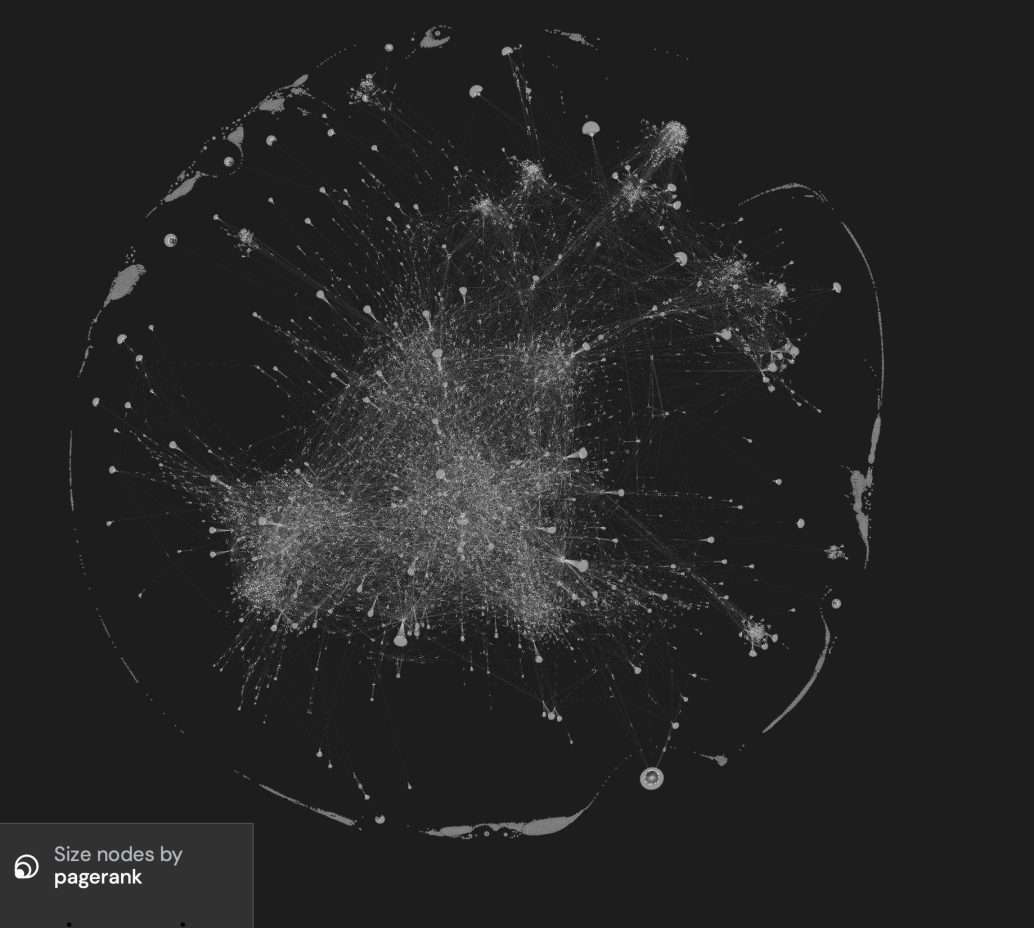

### Dataset after prunning

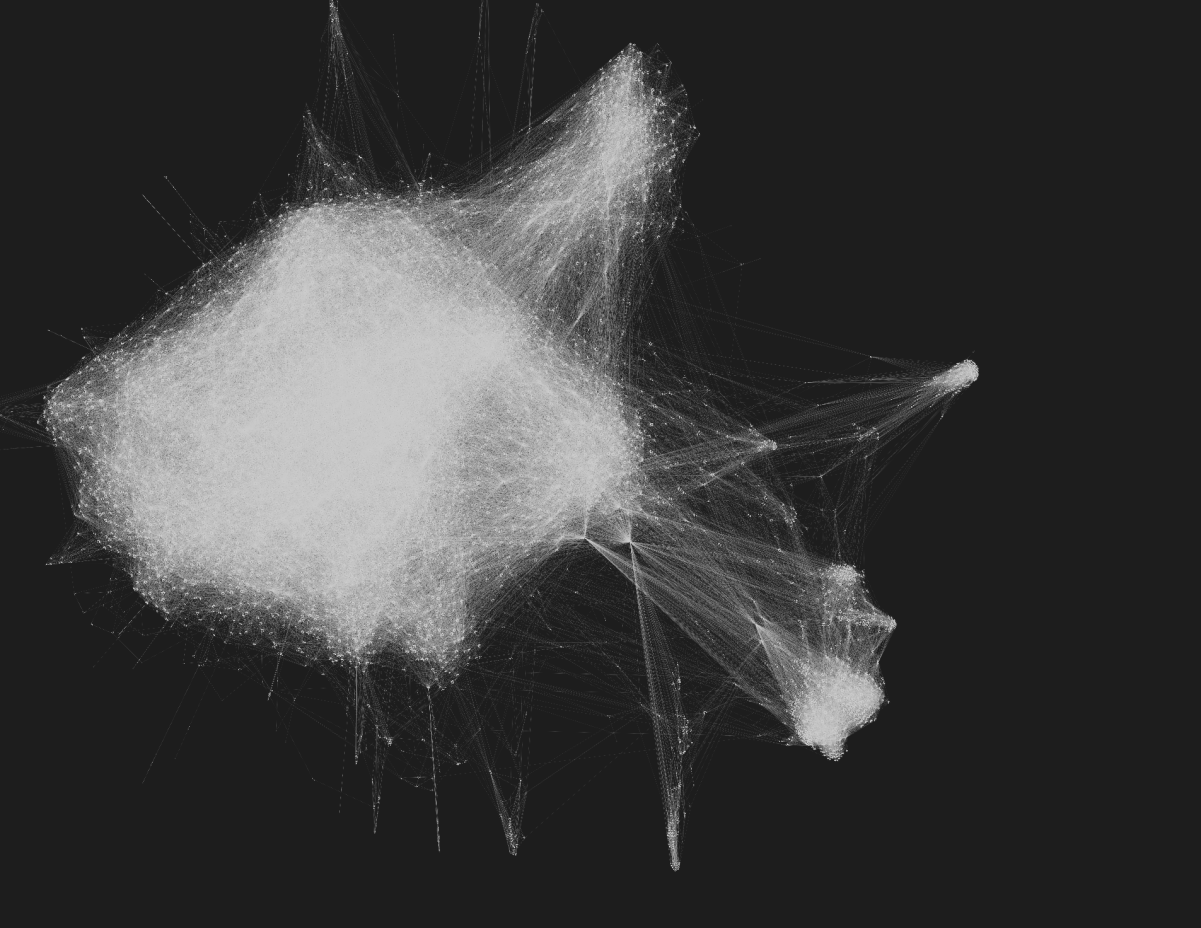

### Dataset showing individuals involved in trial (colored nodes)

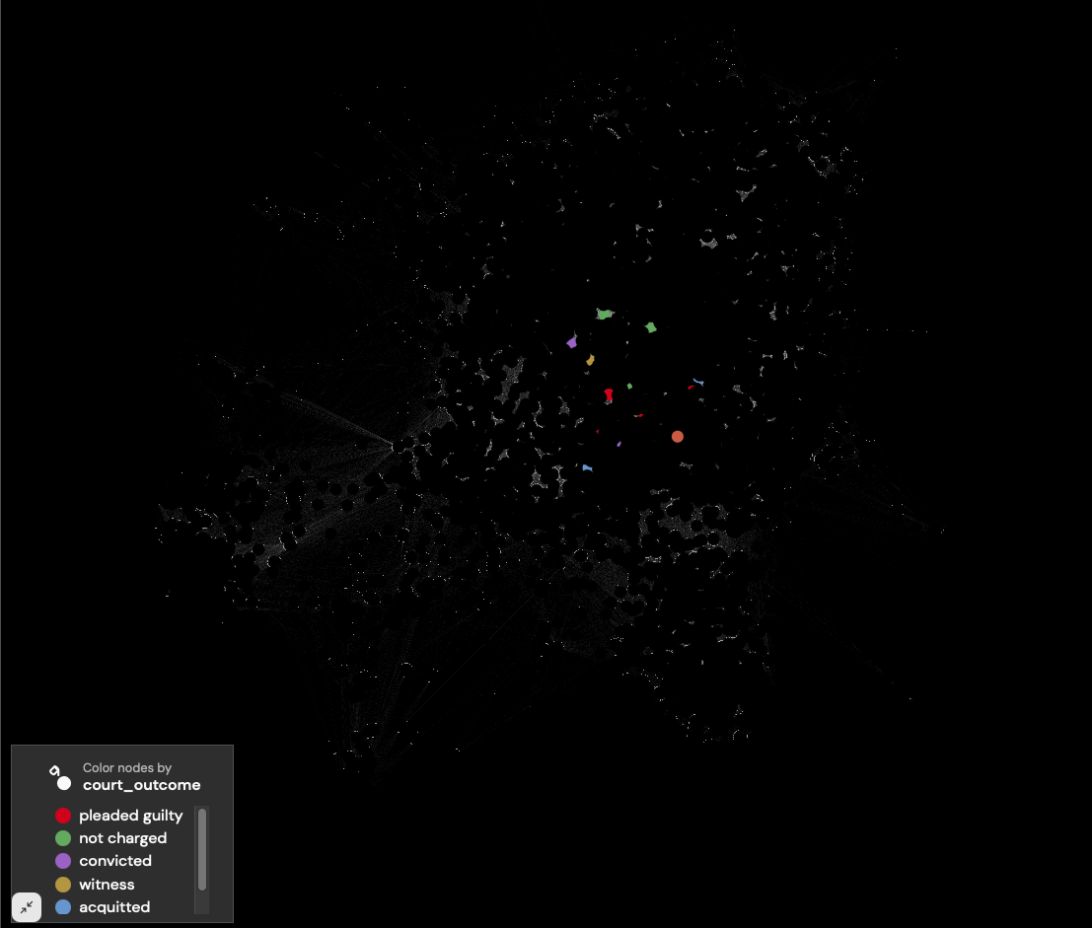

### Enhanced view of individuals involved in trial (not names, court outcome)

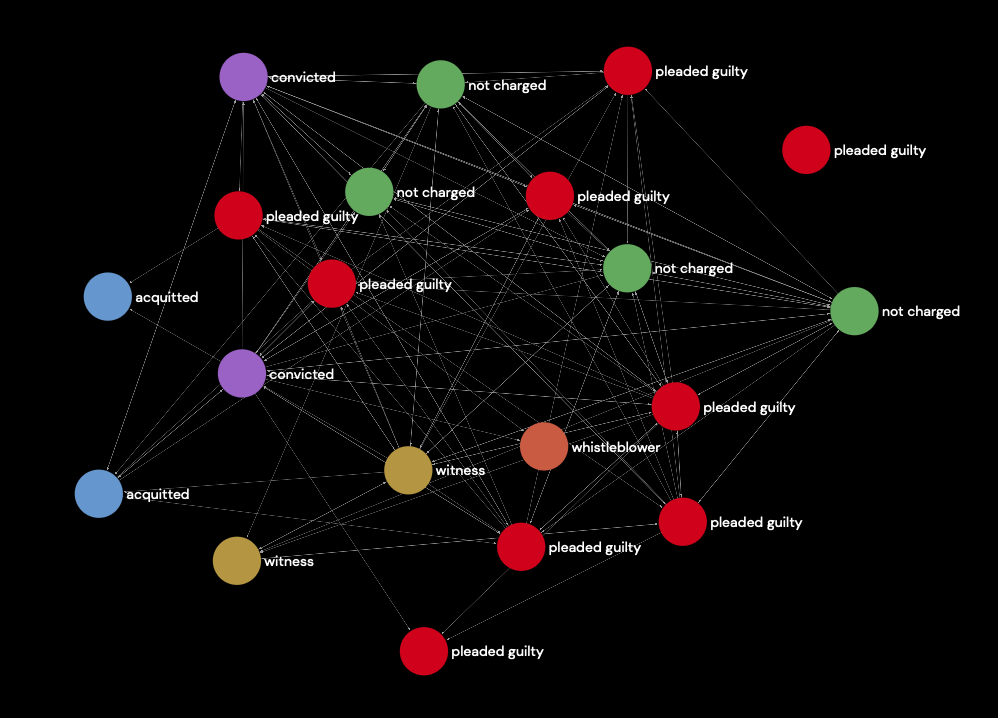

#

# Interpretation

The Enron email network provides an unusually detailed view of how communication operated within a large corporate environment. Each node represents an individual email address, and each link reflects at least one exchange between two people. Link weight indicates the frequency of those exchanges. When plotted, the data reveals a clear organizational structure rather than a random distribution of communication.

The network visualization reveals a dense central core surrounded by smaller, tightly connected clusters. These clusters appear to correspond to departments or project groups, while the central region is dominated by a small number of individuals who served as communication bridges across teams. The structure resembles other corporate networks in which a limited number of highly active individuals facilitate the majority of message flow across the organization.

A particularly interesting feature of this network is the imbalance between routine and executive correspondence. The vast majority of messages are ordinary and procedural, involving daily coordination, scheduling, and project updates. In contrast, a much smaller fraction of the network contains communication tied to managerial oversight and decision making. This division reflects the everyday social rhythm of office life, where most exchanges serve logistical purposes, while a select group manages high-impact information flow. Within the context of Enron, this observation also mirrors the way wrongdoing could develop unnoticed, embedded within normal channels of operation.

When specific nodes are examined more closely in Gephi, ego networks of high-degree users show patterns similar to those described by Fisher (2005). Typical employees maintain small, localized networks with few cross-department connections, while central figures act as information brokers connecting otherwise separate groups. These individuals serve as communication anchors who sustain the efficiency of information flow but also concentrate control in a limited set of actors. This demonstrates how structural position within a communication network can both enhance productivity and introduce vulnerability.

Overall, the visualization portrays Enron as a complex yet uneven communication ecosystem. The presence of concentrated hubs, fragmented subgroups, and bridging individuals illustrates how authority and information can coexist in tension. Even in a company with thousands of employees, a relatively small core of participants exerted disproportionate influence over the organization’s internal communication landscape.

# Reflection

**Summary of Work**  
Our group converted the Enron email dataset into a structured network containing approximately 46,800 nodes and 188,000 links. Each node represents an individual email address, and each link represents a verified exchange between two participants. We processed the data into both CSV and GEXF formats and visualized it in Gephi using the ForceAtlas2 layout. Through cleaning and filtering, we isolated meaningful relationships and reduced noise from less active addresses. This process revealed how communication within Enron was organized around a few highly connected individuals who played central roles in keeping information flowing across departments. 

**Learning Experience**  
Working with this dataset provided an opportunity to see how abstract network theory can be applied to real organizational data. It was rewarding to observe how statistical patterns translated into recognizable human behavior. For instance, we learned how a small number of central actors can hold disproportionate influence, and how even simple data transformations can highlight patterns of authority and collaboration. It also emphasized the importance of data cleaning and validation, since missing or incomplete entries could easily distort the network’s shape. The technical steps of converting raw emails into a graph reinforced our understanding of how structure determines visibility in data analysis.

**Interesting Observations**  
What stands out most is how ordinary the majority of the communication appears. Although Enron is remembered for its financial misconduct, most messages were normal and routine. That contrast made the visualization more meaningful because it placed the extraordinary events of the scandal within the context of everyday corporate communication. The visualization reminded us that behind every network of data are people performing daily tasks, unaware of how their actions will later be interpreted. Seeing these ordinary exchanges next to the connections of key executives made the entire dataset feel less like a record of wrongdoing and more like a reflection of human systems under stress.

**Next Steps**  
With additional time, we would like to expand this work by:  
1. **Time-Based Analysis:** Dividing the dataset by month or quarter to identify shifts in communication density during key events in Enron’s history.  
2. **Role Mapping:** Integrating known employee roles or departments to compare how communication patterns varied by function.  
3. **Ego Network Comparison:** Visualizing smaller subsets of the network centered on specific employees to explore personal influence and information reach.  
4. **Message Features:** Using metadata such as subject lines, attachment presence, or response frequency to identify patterns of urgency and coordination.

**Closing Thoughts**  
This project revealed how network visualization can make complex systems more understandable and human. By examining the structure of communication rather than its content, we gained a new appreciation for how organizations balance order, efficiency, and vulnerability. The Enron dataset remains valuable not just as a case study in corporate collapse, but as a lesson in how communication patterns mirror the health of an organization. The experience reinforced the idea that the way people connect often tells as much of the story as what they say.

**Reference**  
Fisher, D. (2005). *Using egocentric networks to understand communication.* *IEEE Internet Computing, 9*(5), 20–28. https://doi.org/10.1109/MIC.2005.113